In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import sympy as sp
import h5py
import fcs_demo as fcs
from scipy import signal

In [5]:
contrast_values = 0.05
counts_values = 50.0
FWHM = 0.001 #GHz
tau = 500 #us
amp = 0.5
frequency = 0.2

time = np.linspace(0.0, 5e04, 5001)
x_range = np.linspace(2.7, 3.0, time.size) #GHz

In [3]:
def freq_point(x_range, FWHM):
    max_slope_index_1 = np.argmin(np.abs(x_range - (2814 - 0.6*0.5*1000*FWHM)/1000))
    max_slope_index_2 = np.argmin(np.abs(x_range - (2814 - 0.6*0.5*1000*FWHM)/1000))
    freq_1 = x_range[max_slope_index_1]
    freq_2 = x_range[max_slope_index_2]
    return freq_1, freq_2

def arrays(itr, time):
    acf_norm_mag_array = []
    acf_norm_odmr_array1 = []
    acf_norm_odmr_array2 = []


    autocorr_mag_data = np.empty((itr, time.shape[0]))
    autocorr_odmr_data1 = np.empty((itr, time.shape[0]))
    autocorr_odmr_data2 = np.empty((itr, time.shape[0]))

    noisy_odmr_autocorr_1 = [[] for _ in range(itr)]
    noisy_odmr_autocorr_2 = [[] for _ in range(itr)]

    photon_trajectory = np.zeros((itr, time.size))

    noisy_w_1_array = np.empty((itr, time.size))
    noisy_w_2_array = np.empty((itr, time.size))
    return acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2, autocorr_mag_data, autocorr_odmr_data1, autocorr_odmr_data2, noisy_odmr_autocorr_1, noisy_odmr_autocorr_2, photon_trajectory, noisy_w_1_array, noisy_w_2_array

def freq_func(itr, tau, time, _):


    noisy_mag_field_itr = []
    noisy_w_1 = [[] for _ in range(itr)]
    noisy_w_2 = [[] for _ in range(itr)]

    scaling = amp*np.array([np.exp(-t/tau) for t in time])
    white_noise = np.random.normal(size=time.size)

    noisy_mag_field = 0.1*fcs.noisy_magnetic_field(white_noise, scaling) + 20
    noisy_mag_field_itr.append(noisy_mag_field)

    for n, B_noise in enumerate(noisy_mag_field):
        noisy_w1, noisy_w2 = fcs.frequencies(B_noise)

        noisy_w_1[_].append(noisy_w1)
        noisy_w_2[_].append(noisy_w2)
       

    noisy_w_1_array[_, :] = noisy_w_1[_]
    noisy_w_2_array[_, :] = noisy_w_2[_]


    return noisy_w_1, noisy_w_2, noisy_mag_field, noisy_w_1_array, noisy_w_2_array
    
def corr_analysis(noisy_mag_fields, time, photon_trajectory, _, 
                  autocorr_mag_data, autocorr_odmr_data1, autocorr_odmr_data2, 
                  acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2):

    noisy_mag_autocorr = signal.correlate(noisy_mag_fields - np.mean(noisy_mag_fields), noisy_mag_fields - np.mean(noisy_mag_fields), mode = 'full', method = 'fft')[(time.shape[0]-1):]
    noisy_odmr_autocorr1 = signal.correlate(photon_trajectory[_] - np.mean(photon_trajectory[_]), photon_trajectory[_] - np.mean(photon_trajectory[_]), mode = 'full', method = 'fft')[(time.shape[0]-1):]
    # noisy_mag_autocorr = fcs.autocorrelation(noisy_mag_fields - np.mean(noisy_mag_fields), time)
    # noisy_odmr_autocorr1 = fcs.autocorrelation(photon_trajectory[_]- np.mean(photon_trajectory[_]), time)
    noisy_odmr_autocorr2 = fcs.autocorrelation(photon_trajectory[_]- np.mean(photon_trajectory[_]), time)
   
    autocorr_mag_data[_, :]  = noisy_mag_autocorr
    autocorr_odmr_data1[_, :] = noisy_odmr_autocorr1
    autocorr_odmr_data2[_, :] = noisy_odmr_autocorr2



    acf_norm_mag = np.mean(autocorr_mag_data,0)/np.mean(autocorr_mag_data,0)[0]
    acf_norm_odmr1 = np.mean(autocorr_odmr_data1,0)/np.mean(autocorr_odmr_data1,0)[0]
    acf_norm_odmr2 = np.mean(autocorr_odmr_data2,0)/np.mean(autocorr_odmr_data2,0)[0]


    acf_norm_mag_array.append(acf_norm_mag)
    acf_norm_odmr_array1.append(acf_norm_odmr1)
    acf_norm_odmr_array2.append(acf_norm_odmr2)


    return acf_norm_mag, acf_norm_odmr1, acf_norm_odmr2

def avg_corr_analysis(acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2):
    stacked_mag_arrays = np.stack(acf_norm_mag_array, axis=0)
    average_mag_array = np.mean(stacked_mag_arrays, axis=0)

    stacked_odmr_arrays1 = np.stack(acf_norm_odmr_array1, axis=0)
    average_odmr_array1 = np.mean(stacked_odmr_arrays1, axis=0)

    stacked_odmr_arrays2 = np.stack(acf_norm_odmr_array2, axis=0)
    average_odmr_array2 = np.mean(stacked_odmr_arrays2, axis=0)

    model = lm.models.ExponentialModel(prefix = 'e_')
    pars = model.make_params()
    pars['e_amplitude'].set(value = 1.0, min = 0.0, vary = True)
    pars['e_decay'].set(value = tau, min = 0.0)
    avg_noisy_mag_autocorr_fit = model.fit(average_mag_array[1:], x = time[1:], params = pars)
    avg_noisy_odmr_autocorr_fit1 = model.fit(average_odmr_array1[1:], x = time[1:], params = pars)
    avg_noisy_odmr_autocorr_fit2 = model.fit(average_odmr_array2[1:], x = time[1:], params = pars)
    return average_mag_array, average_odmr_array1, average_odmr_array2, avg_noisy_mag_autocorr_fit, avg_noisy_odmr_autocorr_fit1, avg_noisy_odmr_autocorr_fit2

<ipython-input-3-77c66caab738>:71: RuntimeWarning: invalid value encountered in true_divide
  acf_norm_odmr2 = np.mean(autocorr_odmr_data2,0)/np.mean(autocorr_odmr_data2,0)[0]
<ipython-input-3-77c66caab738>:71: RuntimeWarning: invalid value encountered in true_divide
  acf_norm_odmr2 = np.mean(autocorr_odmr_data2,0)/np.mean(autocorr_odmr_data2,0)[0]
<ipython-input-3-77c66caab738>:71: RuntimeWarning: invalid value encountered in true_divide
  acf_norm_odmr2 = np.mean(autocorr_odmr_data2,0)/np.mean(autocorr_odmr_data2,0)[0]
<ipython-input-3-77c66caab738>:71: RuntimeWarning: invalid value encountered in true_divide
  acf_norm_odmr2 = np.mean(autocorr_odmr_data2,0)/np.mean(autocorr_odmr_data2,0)[0]
<ipython-input-3-77c66caab738>:71: RuntimeWarning: invalid value encountered in true_divide
  acf_norm_odmr2 = np.mean(autocorr_odmr_data2,0)/np.mean(autocorr_odmr_data2,0)[0]
<ipython-input-3-77c66caab738>:71: RuntimeWarning: invalid value encountered in true_divide
  acf_norm_odmr2 = np.mean(a

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

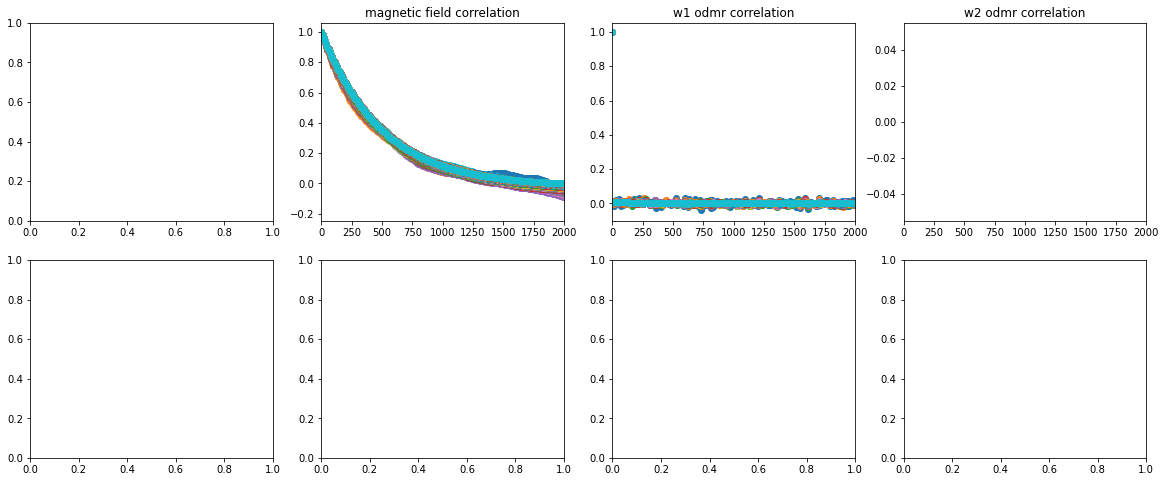

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=False, sharey=False)

itr = 10000

acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2, autocorr_mag_data, autocorr_odmr_data1, autocorr_odmr_data2, noisy_odmr_autocorr_1, noisy_odmr_autocorr_2, photon_trajectory, noisy_w_1_array, noisy_w_2_array = arrays(itr, time)

freq_1, freq_2 = freq_point(x_range, FWHM) 


for w in range(itr):

    noisy_w_1, noisy_w_2, noisy_mag_fields, noisy_w_1_array, noisy_w_2_array = freq_func(itr, tau, time, w)

    noise_odmr_spectrum, noise_noisy_odmr_spectrum = fcs.simulate_ODMR(freq_1, 
                                                                    FWHM, np.asarray(noisy_w_1_array[w, :]), FWHM, np.asarray(noisy_w_2_array[w, :]), contrast_values, counts_values) # you can pass the array directly to the function to avoid another nested loop
                                                                                                                    
                                                                                                                                        # and we only need to calculate the count rate at one frequency
    photon_trajectory[w, :] = np.asarray(noise_noisy_odmr_spectrum)

    acf_norm_mag, acf_norm_odmr1, acf_norm_odmr2 = corr_analysis(noisy_mag_fields, time, photon_trajectory, w, 
                  autocorr_mag_data, autocorr_odmr_data1, autocorr_odmr_data2, 
                  acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2)




    axes[0, 1].plot(time, acf_norm_mag, 'o')
    axes[0, 1].set_title('magnetic field correlation')

    axes[0, 2].plot(time, acf_norm_odmr1, 'o')
    axes[0, 2].set_title('w1 odmr correlation')
    
    axes[0, 3].plot(time, acf_norm_odmr2, 'o')
    axes[0, 3].set_title('w2 odmr correlation')

axes[0, 1].set_xlim(0,2000)
axes[0, 2].set_xlim(0,2000)
axes[0, 3].set_xlim(0,2000)


average_mag_array, average_odmr_array1, average_odmr_array2, avg_noisy_mag_autocorr_fit, avg_noisy_odmr_autocorr_fit1, avg_noisy_odmr_autocorr_fit2 = avg_corr_analysis(acf_norm_mag_array, acf_norm_odmr_array1, acf_norm_odmr_array2)


axes[1, 0].plot(time[1:], avg_noisy_mag_autocorr_fit.best_fit, '--', label = f"Fit, T_fit={avg_noisy_mag_autocorr_fit.params['e_decay'].value:.3f}, \n T_char={tau:.3f}")
axes[1, 0].plot(time[1:], average_mag_array[1:], 'o', label = f'Corr, T_char={tau:.3f}')
axes[1, 0].set_title('magnetic field correlation')
axes[1, 0].legend()

axes[1, 1].plot(time[1:], avg_noisy_odmr_autocorr_fit1.best_fit, '--', label = f"Fit, T_fit={avg_noisy_odmr_autocorr_fit1.params['e_decay'].value:.3f}, \n T_char={tau:.3f}")
axes[1, 1].plot(time[1:], average_odmr_array1[1:], 'o', label = f'Corr, T_char={tau:.3f}')
axes[1, 1].set_title('w1 odmr correlation')
axes[1, 1].legend()

axes[1, 2].plot(time[1:], avg_noisy_odmr_autocorr_fit2.best_fit, '--', label = f"Fit, T_fit={avg_noisy_odmr_autocorr_fit2.params['e_decay'].value:.3f}, \n T_char={tau:.3f}")
axes[1, 2].plot(time[1:], average_odmr_array2[1:], 'o', label = f'Corr, T_char={tau:.3f}')
axes[1, 2].set_title('w2 odmr correlation')
axes[1, 2].legend()

axes[1, 0].set_xlim(0,1000)
axes[1, 1].set_xlim(0,1000)
axes[1, 2].set_xlim(0,1000)
      
axes[0, 0].plot(time, photon_trajectory[0,:], 'o', alpha = 0.2)
axes[0, 0].set_title('photon trajectory')
        


In [19]:
hf.close()

hf = h5py.File('data.h5', 'w')
hf.create_dataset('contrast_values', data=contrast_values)
hf.create_dataset('counts_values', data=counts_values)
hf.create_dataset('FWHM_values', data=FWHM)
hf.create_dataset('tau_values', data=tau)
hf.create_dataset('amplitude_values', data=amp)
hf.create_dataset('freq_1', data = noisy_w1)
hf.create_dataset('freq_2', data = noisy_w2)
hf.create_dataset('freq_1_pos', data=freq_1)
hf.create_dataset('freq_2_pos', data=freq_2)
hf.create_dataset('mag_autocorrelation', data = stacked_mag_arrays)
hf.create_dataset('odmr_autocorrelation_1', data = stacked_odmr_arrays1)
hf.create_dataset('odmr_autocorrelation_2', data = stacked_odmr_arrays2)
hf.create_dataset('average_magfield_autocorrelaiton', data = average_mag_array)
hf.create_dataset('average_magfield_autocorrelaiton_fit', data = avg_noisy_mag_autocorr_fit.best_fit)
hf.create_dataset('average_odmr_autocorrelaiton_1', data = average_odmr_array1)
hf.create_dataset('average_odmr_autocorrelaiton_2', data = average_odmr_array2)
hf.create_dataset('average_odmr_autocorrelaiton_fit_1', data = avg_noisy_odmr_autocorr_fit1.best_fit)
hf.create_dataset('average_odmr_autocorrelaiton_fit_2', data = avg_noisy_odmr_autocorr_fit2.best_fit)
hf.close()



In [23]:
hf.close()

hf = h5py.File('data.h5', 'r')
hf.keys()
FWHM = hf.get('FWHM_values')
print(FWHM)

hf.close()

<HDF5 dataset "FWHM_values": shape (1,), type "<f8">
